In [2]:
import os
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import cv2
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import random

In [3]:
def random_grayscale(image, p=0.5):
    """Apply grayscaling to the image with probability p."""
    if np.random.rand() < p:
        gray_image = tf.image.rgb_to_grayscale(image)
        # plt.imshow(gray_image/255.0)
        rgb_gray_image = tf.image.grayscale_to_rgb(gray_image)
        # plt.imshow(rgb_gray_image/255.0)
        return rgb_gray_image 

    return image

# Define a function to apply histogram equalization to images
def histogram_equalization(image):
    # Convert to array
    img_array = img_to_array(image)

    # Convert to YUV color space
    yuv_img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2YUV)

    # Apply histogram equalization to the Y channel
    yuv_img_array[:, :, 0] = cv2.equalizeHist(yuv_img_array[:, :, 0].astype('uint8'))

    # Convert back to RGB color space
    equalized_img_array = cv2.cvtColor(yuv_img_array, cv2.COLOR_YUV2RGB)

    return equalized_img_array


In [4]:

# Define models
# Define a common CNN model
def create_common_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer
    return model

# Define a function to create a model using ResNet-50 for transfer learning
def create_resnet50_transfer_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    # Unfreeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Define the ResNet18 model for transfer learning
def create_resnet18_transfer_model(input_shape, num_classes):
    # Load ResNet model from TensorFlow Hub
    resnet_hub_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"  # Example URL for ResNet50
    resnet_hub_model = hub.KerasLayer(resnet_hub_url, input_shape=input_shape, trainable=False)

    model = Sequential([
        resnet_hub_model,
        Dense(1024, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model




In [6]:
# Define constants
IMAGE_SIZE = (224, 224)
NUM_EPOCHS = 30
COLOR_MODE = 'rgb'
SEED = 123
batch_size = 4

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Data preparation
# Define the path of datasets
dataset_path = 'dataset'
val_dataset_path = 'val_dataset'

# Preprocessing and data augmentation setup
# Create data generators

def custom_preprocessing_function(image):
    # Apply histogram equalization or other preprocessing steps first
    image = histogram_equalization(image)
    # Then apply random grayscaling
    image = random_grayscale(image)
    return image

datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocessing_function,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    dataset_path,
    shuffle=True,
    seed=SEED,
    color_mode=COLOR_MODE,
    batch_size=batch_size,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    subset='training'
)
test_generator = datagen.flow_from_directory(
    dataset_path,
    shuffle=True,
    seed=SEED,
    color_mode=COLOR_MODE,
    batch_size=batch_size,
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    subset='validation'
)
val_generator = val_datagen.flow_from_directory(
    val_dataset_path,
    shuffle=False,
    seed=SEED,
    color_mode=COLOR_MODE,
    batch_size=1,
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)


Found 39 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [7]:
# # Fetch a batch of images
# images, labels = next(train_generator)

# # Function to display images in a grid
# def show_images(images, n_rows, n_cols, scale=1):
#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * scale, n_rows * scale))
#     axes = axes.flatten()
#     for img, ax in zip(images, axes):
#         ax.imshow(img)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()

# # Display the images
# show_images(images, n_rows=2, n_cols=2, scale=3)

In [8]:
# Define a function to run experiments varifying batch size and model type
def run_experiment(batch_size, model_type, augmentation_flag, epochs):
    # Define constants
    IMAGE_SIZE = (224, 224)
    NUM_EPOCHS = epochs
    COLOR_MODE = 'rgb'
    SEED = 123
    

    # Data preparation
    # Define the path of datasets
    dataset_path = 'dataset'
    val_dataset_path = 'val_dataset'

    # Preprocessing and data augmentation setup
    # Create data generators
    if augmentation_flag == 1:
        datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=custom_preprocessing_function,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2
    )
    else:
        datagen = ImageDataGenerator(
            rescale=1./255,
            preprocessing_function=histogram_equalization,
            validation_split=0.2
        )
    val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = datagen.flow_from_directory(
        dataset_path,
        shuffle=True,
        seed=SEED,
        color_mode=COLOR_MODE,
        batch_size=batch_size,
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        subset='training'
    )
    test_generator = datagen.flow_from_directory(
        dataset_path,
        shuffle=True,
        seed=SEED,
        color_mode=COLOR_MODE,
        batch_size=batch_size,
        target_size=IMAGE_SIZE,
        class_mode='categorical',
        subset='validation'
    )
    val_generator = val_datagen.flow_from_directory(
        val_dataset_path,
        shuffle=False,
        seed=SEED,
        color_mode=COLOR_MODE,
        batch_size=1,
        target_size=IMAGE_SIZE,
        class_mode='categorical'
    )


    # Append the color channel to create input_shape
    input_shape = IMAGE_SIZE+(3,)

    # Select model
    if model_type == 'common':
        model = create_common_cnn(input_shape=input_shape, num_classes=4)
    elif model_type == 'resnet50':
        model = create_resnet50_transfer_model(input_shape=input_shape, num_classes=4)
    elif model_type == 'resnet18':
        model = create_resnet18_transfer_model(input_shape=input_shape, num_classes=4)

    # Compile the model
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # To deal with the problem in training of something with augmentation
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


    # Define early stopping criteria
    early_stopping = EarlyStopping(
        monitor='accuracy', 
        patience=5,  # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True
    )
    
    # Train the model
    history = model.fit(
        train_generator,
        # steps_per_epoch=math.ceil(len(train_generator)),
        epochs=NUM_EPOCHS,
        validation_data=test_generator,
        # validation_steps=math.ceil(len(train_generator)),
        # callbacks=[early_stopping]
    )


    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy ({model_type}, {batch_size}, {augmentation_flag})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    plt.show()

    val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_generator))
    print(f'val_loss: {val_loss}, val_accuracy: {val_accuracy}')


Found 39 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


Found 20 images belonging to 4 classes.
Epoch 1/40
10/10 [==============================] - 4s 349ms/step - loss: 6.3495 - accuracy: 0.2564 - val_loss: 1.1958 - val_accuracy: 0.5000
Epoch 2/40
10/10 [==============================] - 3s 300ms/step - loss: 1.3892 - accuracy: 0.3846 - val_loss: 1.3396 - val_accuracy: 0.3750
Epoch 3/40
10/10 [==============================] - 3s 313ms/step - loss: 1.3721 - accuracy: 0.4103 - val_loss: 1.3591 - val_accuracy: 0.5000
Epoch 4/40
10/10 [==============================] - 3s 317ms/step - loss: 1.4183 - accuracy: 0.3333 - val_loss: 1.3641 - val_accuracy: 0.5000
Epoch 5/40
10/10 [==============================] - 3s 315ms/step - loss: 1.3212 - accuracy: 0.3077 - val_loss: 1.2152 - val_accuracy: 0.3750
Epoch 6/40
10/10 [==============================] - 3s 321ms/step - loss: 1.3697 - accuracy: 0.3077 - val_loss: 1.3553 - val_accuracy: 0.6250
Epoch 7/40
10/10 [==============================] - 3s 326ms/step - loss: 1.2929 - accuracy: 0.4615 - val_lo

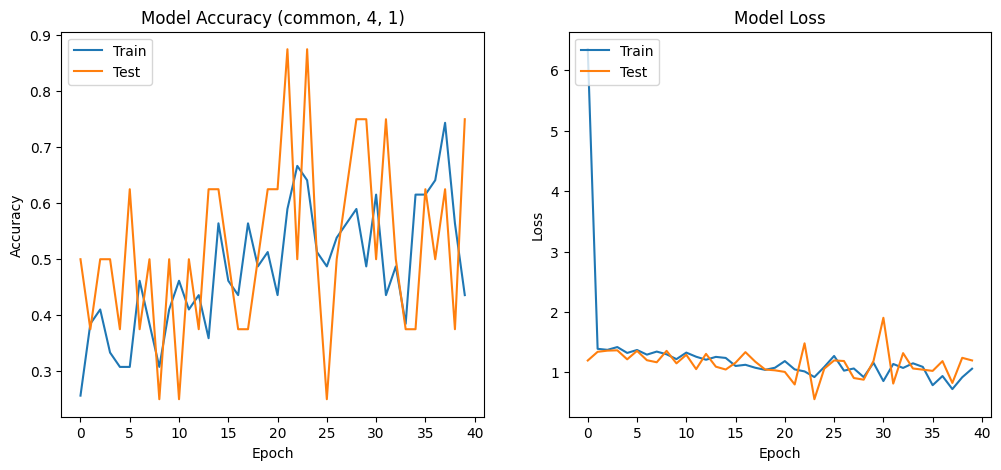

20/20 [==============================] - 0s 21ms/step - loss: 1.3872 - accuracy: 0.3000
val_loss: 1.3872498273849487, val_accuracy: 0.30000001192092896
Found 39 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/40
5/5 [==============================] - 4s 640ms/step - loss: 13.7584 - accuracy: 0.2308 - val_loss: 2.8072 - val_accuracy: 0.2500
Epoch 2/40
5/5 [==============================] - 3s 522ms/step - loss: 2.0358 - accuracy: 0.2821 - val_loss: 1.5839 - val_accuracy: 0.2500
Epoch 3/40
5/5 [==============================] - 3s 537ms/step - loss: 1.4899 - accuracy: 0.2308 - val_loss: 1.3710 - val_accuracy: 0.1250
Epoch 4/40
5/5 [==============================] - 3s 529ms/step - loss: 1.3731 - accuracy: 0.3333 - val_loss: 1.3854 - val_accuracy: 0.3750
Epoch 5/40
5/5 [==============================] - 3s 540ms/step - loss: 1.3717 - accuracy: 0.3846 - val_loss: 1.3524 - val_accuracy: 0.3750
Epoch 6/40
5/5 [============

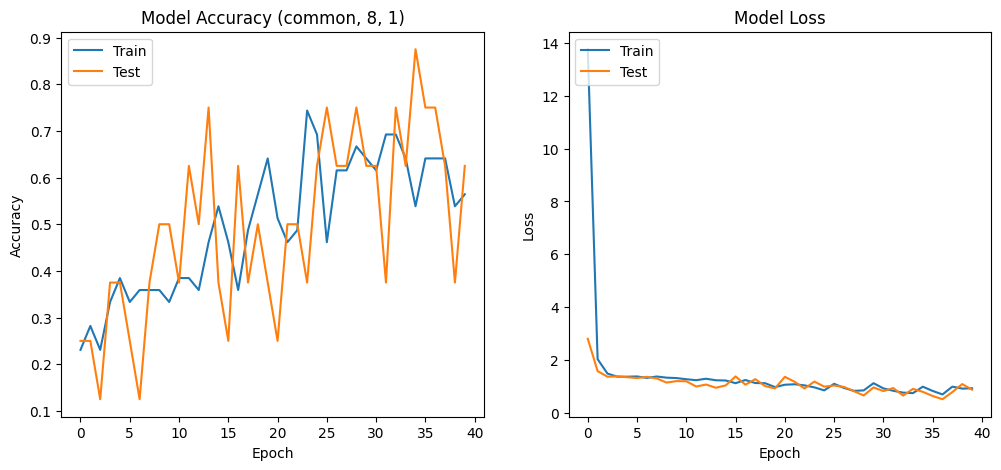

20/20 [==============================] - 1s 28ms/step - loss: 1.3422 - accuracy: 0.6000
val_loss: 1.342150330543518, val_accuracy: 0.6000000238418579
Found 39 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/40
3/3 [==============================] - 4s 990ms/step - loss: 13.4529 - accuracy: 0.3077 - val_loss: 13.0436 - val_accuracy: 0.2500
Epoch 2/40
3/3 [==============================] - 3s 823ms/step - loss: 7.2289 - accuracy: 0.2821 - val_loss: 2.1448 - val_accuracy: 0.3750
Epoch 3/40
3/3 [==============================] - 3s 1s/step - loss: 1.4060 - accuracy: 0.3333 - val_loss: 1.3755 - val_accuracy: 0.3750
Epoch 4/40
3/3 [==============================] - 3s 771ms/step - loss: 1.3603 - accuracy: 0.3333 - val_loss: 1.3855 - val_accuracy: 0.3750
Epoch 5/40
3/3 [==============================] - 3s 790ms/step - loss: 1.3681 - accuracy: 0.3333 - val_loss: 1.3894 - val_accuracy: 0.2500
Epoch 6/40
3/3 [================

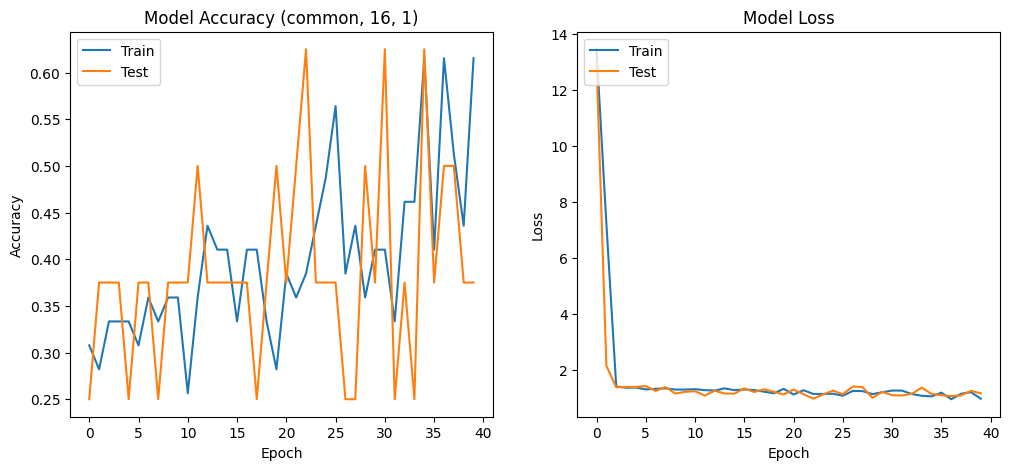

20/20 [==============================] - 1s 25ms/step - loss: 1.9158 - accuracy: 0.3500
val_loss: 1.9157556295394897, val_accuracy: 0.3499999940395355


In [11]:
# Running experiments
batch_sizes = [4,8,16,32]
# model_types = ['common', 'resnet50', 'resnet18']
model_types = ['common']
aug_flags = [0, 1]


run_experiment(4, 'common', 1, 40)
run_experiment(8, 'common', 1, 40)
run_experiment(16, 'common', 1, 40)

            
# https://stackoverflow.com/questions/63636565/datagen-flow-from-directory-function
# https://stackoverflow.com/questions/59864408/tensorflowyour-input-ran-out-of-data

Found 39 images belonging to 4 classes.


Found 8 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/80
10/10 [==============================] - 5s 354ms/step - loss: 4.0922 - accuracy: 0.2564 - val_loss: 1.3645 - val_accuracy: 0.2500
Epoch 2/80
10/10 [==============================] - 3s 325ms/step - loss: 1.3886 - accuracy: 0.2564 - val_loss: 1.2851 - val_accuracy: 0.7500
Epoch 3/80
10/10 [==============================] - 3s 336ms/step - loss: 1.3925 - accuracy: 0.3590 - val_loss: 1.3339 - val_accuracy: 0.2500
Epoch 4/80
10/10 [==============================] - 3s 331ms/step - loss: 1.3434 - accuracy: 0.3333 - val_loss: 1.2451 - val_accuracy: 0.1250
Epoch 5/80
10/10 [==============================] - 3s 338ms/step - loss: 1.3472 - accuracy: 0.2821 - val_loss: 1.5497 - val_accuracy: 0.3750
Epoch 6/80
10/10 [==============================] - 4s 353ms/step - loss: 1.2362 - accuracy: 0.4872 - val_loss: 1.3256 - val_accuracy: 0.2500
Epoch 7/80
10/10 [==============================] - 4s 349ms/step - l

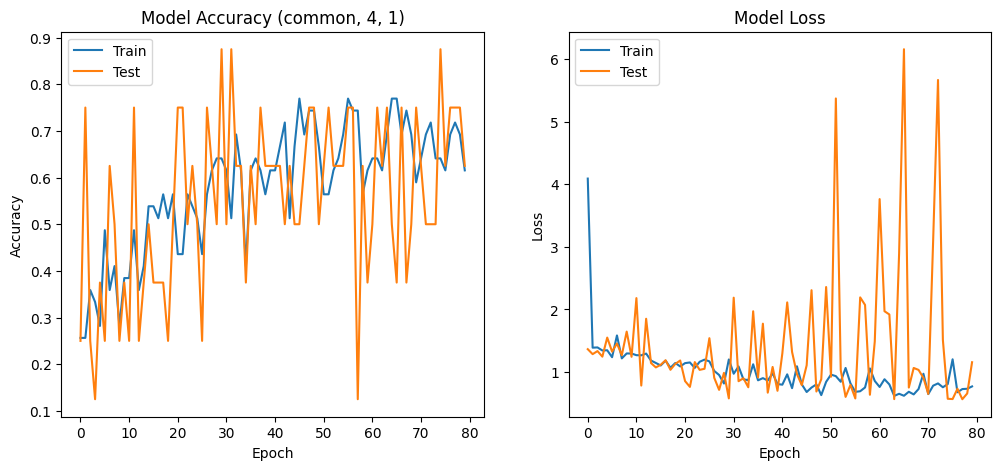

20/20 [==============================] - 1s 23ms/step - loss: 2.0257 - accuracy: 0.3000
val_loss: 2.0257174968719482, val_accuracy: 0.30000001192092896
Found 39 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/80
5/5 [==============================] - 5s 737ms/step - loss: 8.4675 - accuracy: 0.2821 - val_loss: 4.3787 - val_accuracy: 0.3750
Epoch 2/80
5/5 [==============================] - 3s 676ms/step - loss: 2.1712 - accuracy: 0.2821 - val_loss: 1.3840 - val_accuracy: 0.2500
Epoch 3/80
5/5 [==============================] - 3s 622ms/step - loss: 1.3682 - accuracy: 0.2564 - val_loss: 1.3920 - val_accuracy: 0.1250
Epoch 4/80
5/5 [==============================] - 3s 634ms/step - loss: 1.3565 - accuracy: 0.3077 - val_loss: 1.3783 - val_accuracy: 0.2500
Epoch 5/80
5/5 [==============================] - 3s 633ms/step - loss: 1.2725 - accuracy: 0.3333 - val_loss: 1.3461 - val_accuracy: 0.2500
Epoch 6/80
5/5 [=============

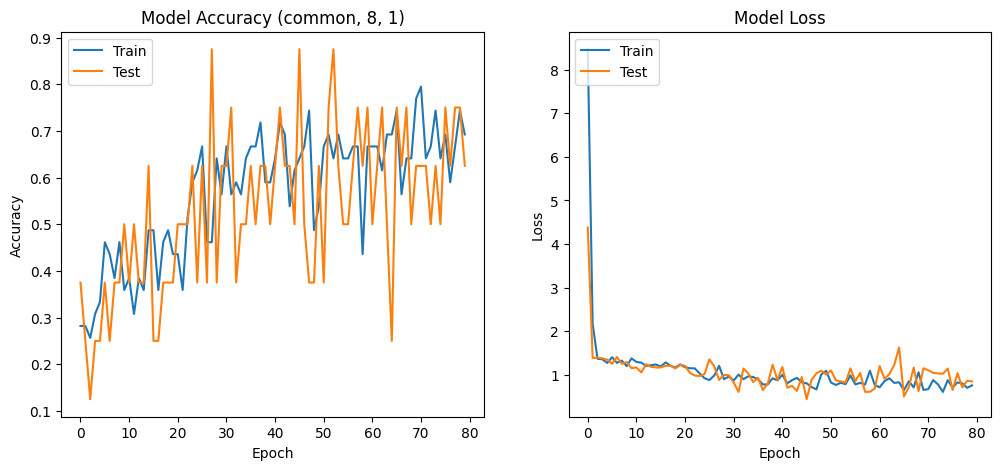

20/20 [==============================] - 1s 27ms/step - loss: 2.0221 - accuracy: 0.4500
val_loss: 2.022063732147217, val_accuracy: 0.44999998807907104
Found 39 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/80
3/3 [==============================] - 6s 2s/step - loss: 7.5684 - accuracy: 0.3077 - val_loss: 5.8552 - val_accuracy: 0.2500
Epoch 2/80
3/3 [==============================] - 3s 967ms/step - loss: 3.7838 - accuracy: 0.2564 - val_loss: 1.4806 - val_accuracy: 0.2500
Epoch 3/80
3/3 [==============================] - 3s 994ms/step - loss: 1.4063 - accuracy: 0.2821 - val_loss: 1.4110 - val_accuracy: 0.3750
Epoch 4/80
3/3 [==============================] - 3s 1s/step - loss: 1.3424 - accuracy: 0.3590 - val_loss: 1.3816 - val_accuracy: 0.3750
Epoch 5/80
3/3 [==============================] - 3s 979ms/step - loss: 1.3327 - accuracy: 0.3846 - val_loss: 1.3786 - val_accuracy: 0.2500
Epoch 6/80
3/3 [====================

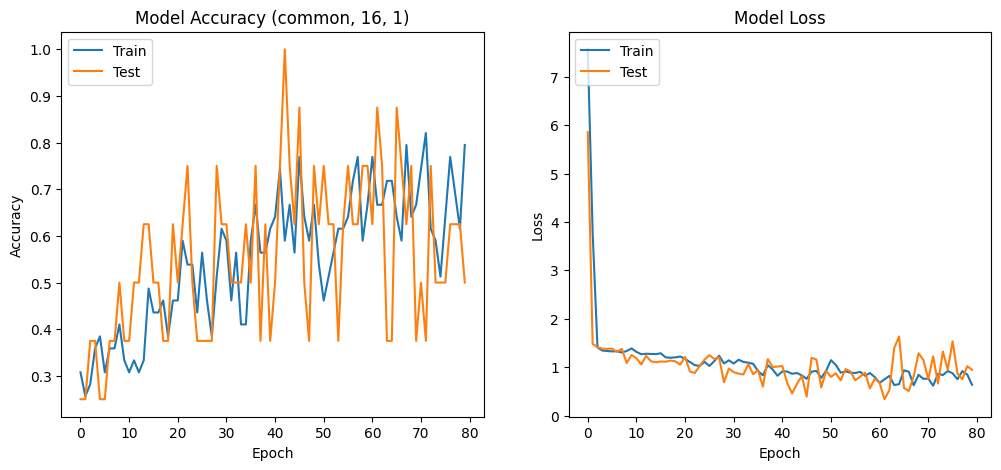

20/20 [==============================] - 1s 23ms/step - loss: 1.4360 - accuracy: 0.4000
val_loss: 1.4359891414642334, val_accuracy: 0.4000000059604645


In [12]:
run_experiment(4, 'common', 1, 80)
run_experiment(8, 'common', 1, 80)
run_experiment(16, 'common', 1, 80)
            
# https://stackoverflow.com/questions/63636565/datagen-flow-from-directory-function
# https://stackoverflow.com/questions/59864408/tensorflowyour-input-ran-out-of-data

Found 39 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/40
3/3 [==============================] - 4s 702ms/step - loss: 5.6837 - accuracy: 0.3333 - val_loss: 10.0361 - val_accuracy: 0.2500
Epoch 2/40
3/3 [==============================] - 2s 527ms/step - loss: 5.8595 - accuracy: 0.2564 - val_loss: 1.2213 - val_accuracy: 0.3750
Epoch 3/40
3/3 [==============================] - 2s 519ms/step - loss: 0.7536 - accuracy: 0.6410 - val_loss: 1.2568 - val_accuracy: 0.3750
Epoch 4/40
3/3 [==============================] - 2s 484ms/step - loss: 0.3407 - accuracy: 0.9231 - val_loss: 0.9574 - val_accuracy: 0.6250
Epoch 5/40
3/3 [==============================] - 2s 526ms/step - loss: 0.1067 - accuracy: 0.9744 - val_loss: 1.3091 - val_accuracy: 0.3750
Epoch 6/40
3/3 [==============================] - 2s 524ms/step - loss: 0.0516 - accuracy: 1.0000 - val_loss: 1.1852 - val_accuracy: 0.6250
Epoch 7/40
3/3 [========================

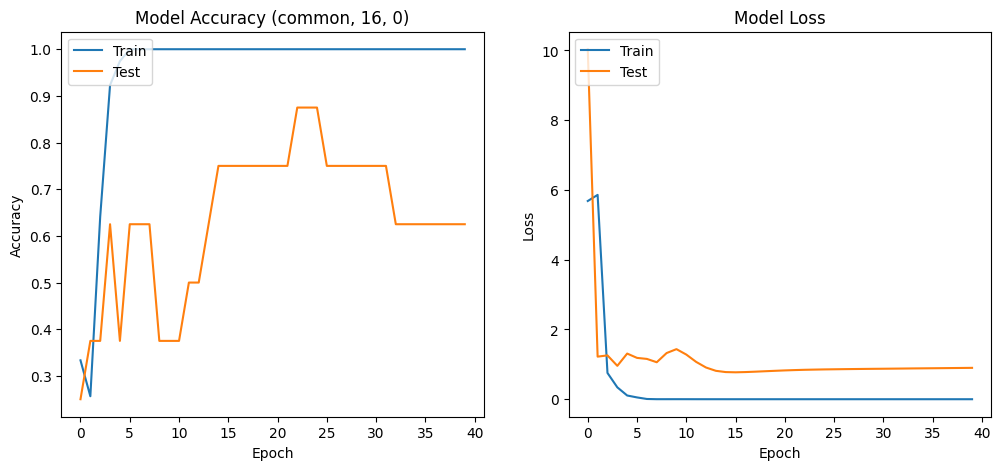

20/20 [==============================] - 1s 46ms/step - loss: 2.9207 - accuracy: 0.3000
val_loss: 2.920684576034546, val_accuracy: 0.30000001192092896


In [12]:
# Running experiments
batch_sizes = [4,8,16,32]
# model_types = ['common', 'resnet50', 'resnet18']
model_types = ['common']
aug_flags = [0, 1]


run_experiment(16, 'common', 0, 40)


Found 39 images belonging to 4 classes.
Found 8 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/80
3/3 [==============================] - 4s 894ms/step - loss: 8.5890 - accuracy: 0.2051 - val_loss: 12.2311 - val_accuracy: 0.3750
Epoch 2/80
3/3 [==============================] - 2s 628ms/step - loss: 8.4871 - accuracy: 0.3590 - val_loss: 2.1117 - val_accuracy: 0.2500
Epoch 3/80
3/3 [==============================] - 2s 894ms/step - loss: 1.2438 - accuracy: 0.5128 - val_loss: 1.3376 - val_accuracy: 0.3750
Epoch 4/80
3/3 [==============================] - 3s 863ms/step - loss: 0.7588 - accuracy: 0.8462 - val_loss: 1.4475 - val_accuracy: 0.3750
Epoch 5/80
3/3 [==============================] - 3s 1s/step - loss: 0.4019 - accuracy: 0.8205 - val_loss: 1.3768 - val_accuracy: 0.3750
Epoch 6/80
3/3 [==============================] - 3s 1s/step - loss: 0.1783 - accuracy: 1.0000 - val_loss: 1.0750 - val_accuracy: 0.6250
Epoch 7/80
3/3 [==============================

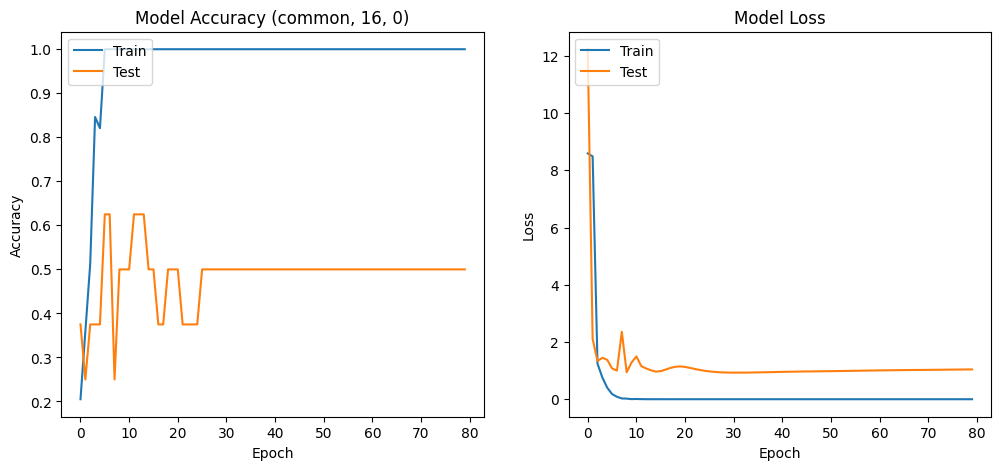

20/20 [==============================] - 1s 51ms/step - loss: 2.7160 - accuracy: 0.3000
val_loss: 2.7160332202911377, val_accuracy: 0.30000001192092896


In [13]:
# Running experiments
batch_sizes = [4,8,16,32]
# model_types = ['common', 'resnet50', 'resnet18']
model_types = ['common']
aug_flags = [0, 1]


run_experiment(16, 'common', 0, 80)


Found 39 images belonging to 4 classes.
Found 8 images belonging to 4 classes.


Found 20 images belonging to 4 classes.
Epoch 1/40
2/2 [==============================] - 3s 849ms/step - loss: 4.4302 - accuracy: 0.1282 - val_loss: 20.7367 - val_accuracy: 0.3750
Epoch 2/40
2/2 [==============================] - 2s 555ms/step - loss: 18.3699 - accuracy: 0.3333 - val_loss: 4.4885 - val_accuracy: 0.2500
Epoch 3/40
2/2 [==============================] - 2s 1s/step - loss: 2.7722 - accuracy: 0.2308 - val_loss: 1.8067 - val_accuracy: 0.2500
Epoch 4/40
2/2 [==============================] - 2s 1s/step - loss: 1.2634 - accuracy: 0.3590 - val_loss: 1.4089 - val_accuracy: 0.2500
Epoch 5/40
2/2 [==============================] - 2s 513ms/step - loss: 0.9197 - accuracy: 0.6667 - val_loss: 1.4393 - val_accuracy: 0.3750
Epoch 6/40
2/2 [==============================] - 2s 553ms/step - loss: 0.8029 - accuracy: 0.5897 - val_loss: 1.2650 - val_accuracy: 0.3750
Epoch 7/40
2/2 [==============================] - 2s 475ms/step - loss: 0.4187 - accuracy: 0.8718 - val_loss: 1.1290 - val_a

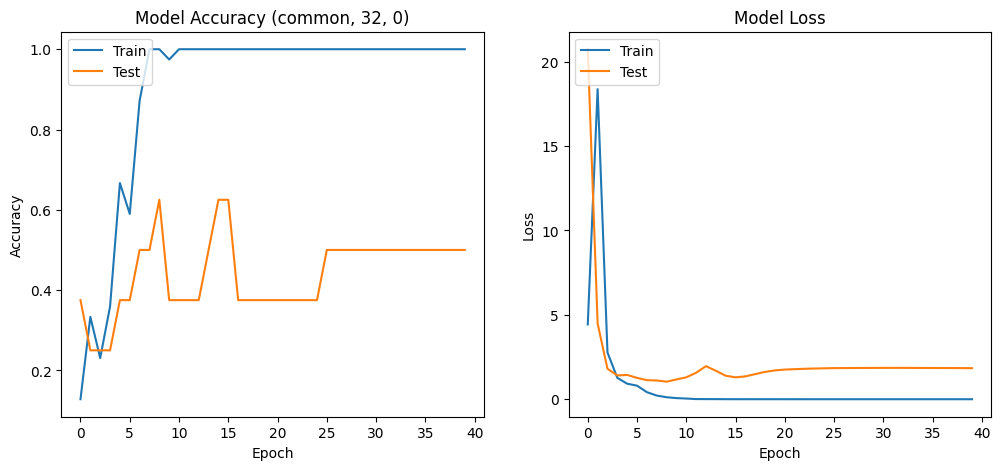

20/20 [==============================] - 1s 24ms/step - loss: 2.8565 - accuracy: 0.2500
val_loss: 2.8564822673797607, val_accuracy: 0.25


In [9]:
run_experiment(32, 'common', 0, 40)


Found 39 images belonging to 4 classes.


Found 8 images belonging to 4 classes.
Found 20 images belonging to 4 classes.
Epoch 1/60
2/2 [==============================] - 3s 796ms/step - loss: 4.7325 - accuracy: 0.1282 - val_loss: 35.2877 - val_accuracy: 0.3750
Epoch 2/60
2/2 [==============================] - 2s 544ms/step - loss: 34.1848 - accuracy: 0.3333 - val_loss: 13.1207 - val_accuracy: 0.2500
Epoch 3/60
2/2 [==============================] - 2s 552ms/step - loss: 12.6763 - accuracy: 0.2308 - val_loss: 5.4656 - val_accuracy: 0.2500
Epoch 4/60
2/2 [==============================] - 2s 524ms/step - loss: 3.8702 - accuracy: 0.3077 - val_loss: 1.8321 - val_accuracy: 0.2500
Epoch 5/60
2/2 [==============================] - 2s 1s/step - loss: 1.5090 - accuracy: 0.5128 - val_loss: 1.6138 - val_accuracy: 0.5000
Epoch 6/60
2/2 [==============================] - 2s 1s/step - loss: 0.8515 - accuracy: 0.6923 - val_loss: 1.1732 - val_accuracy: 0.5000
Epoch 7/60
2/2 [==============================] - 2s 1s/step - loss: 0.5877 - accur

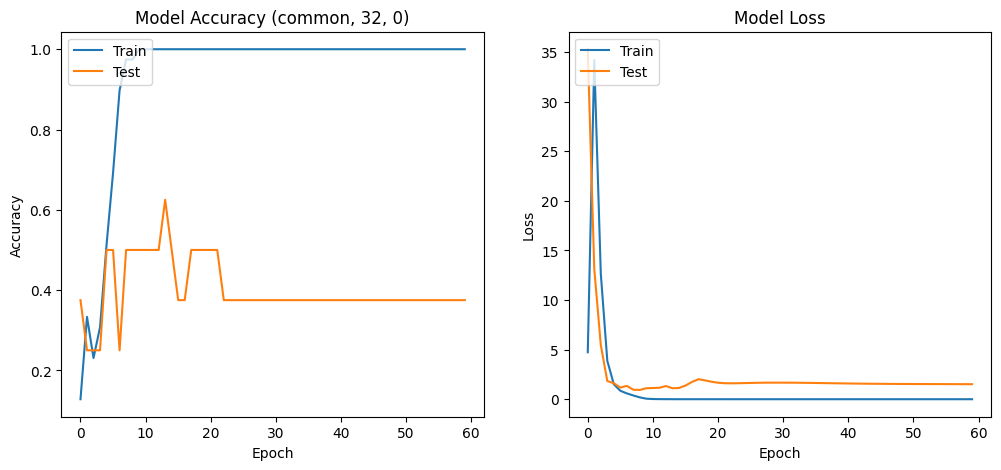

20/20 [==============================] - 0s 22ms/step - loss: 2.8472 - accuracy: 0.3500
val_loss: 2.847151279449463, val_accuracy: 0.3499999940395355


In [10]:
# Running experiments
batch_sizes = [4,8,16,32]
# model_types = ['common', 'resnet50', 'resnet18']
model_types = ['common']
aug_flags = [0, 1]


run_experiment(32, 'common', 0, 60)


In [9]:
import fiftyone as fo
import fiftyone.zoo as foz

# Load the Open Images Dataset (only the dataset's info, not the actual data)
dataset = foz.load_zoo_dataset("open-images-v6", split="validation", only_metadata=True)

# Get the list of class labels in the dataset
print(dataset.default_classes)

 100% |███████████████| 41620/41620 [2.6h elapsed, 0s remaining, 15.9 files/s]      
Dataset info written to 'C:\Users\YE KIM\fiftyone\open-images-v6\info.json'
Ignoring unsupported parameter 'only_metadata' for importer type <class 'fiftyone.utils.openimages.OpenImagesV6DatasetImporter'>
Loading 'open-images-v6' split 'validation'
 100% |█████████████| 41620/41620 [1.9h elapsed, 0s remaining, 16.9 samples/s]      
Dataset 'open-images-v6-validation' created
['Accordion', 'Adhesive tape', 'Aircraft', 'Airplane', 'Alarm clock', 'Alpaca', 'Ambulance', 'Animal', 'Ant', 'Antelope', 'Apple', 'Armadillo', 'Artichoke', 'Auto part', 'Axe', 'Backpack', 'Bagel', 'Baked goods', 'Balance beam', 'Ball', 'Balloon', 'Banana', 'Band-aid', 'Banjo', 'Barge', 'Barrel', 'Baseball bat', 'Baseball glove', 'Bat (Animal)', 'Bathroom accessory', 'Bathroom cabinet', 'Bathtub', 'Beaker', 'Bear', 'Bed', 'Bee', 'Beehive', 'Beer', 'Beetle', 'Bell pepper', 'Belt', 'Bench', 'Bicycle', 'Bicycle helmet', 'Bicycle wheel

In [15]:
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    label_types=[ "classifications"],
    classes = ["Picture frame"],
    max_samples=100,
    seed=51,
    shuffle=True,
    dataset_name="open-images-food",
)

session = fo.launch_app(dataset.view())


Necessary images already downloaded
Existing download of split 'validation' is sufficient
Loading existing dataset 'open-images-food'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
